In [74]:
import os, sys
import glob
import numpy as np
import pandas as pd
import librosa
import pprint
import simplejson
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Audio, HTML, clear_output, display
from tqdm import tqdm

In [75]:
filename = '9VhxpHgPTy8_005'
audio_path = 'audio/ballet'
skeleton_path = 'cplskeleton_final/ballet'

In [77]:
y, sr = librosa.load(os.path.join(audio_path, filename + '.webm'))

In [78]:
poses = sorted(glob.glob(os.path.join(skeleton_path, filename + '*')))

In [79]:
Audio(y, rate=sr)

In [80]:
def toJSON(x):
    """
    Convert Let's dance data to JSON format by the person id and
    the keypoint name.
    """
    result = {}
    curr = {}
    name = None
    for line in x:
        data = simplejson.loads(line)
        for row in data:
            if type(row) == list and len(row) == 3:
                curr[row[0]] = (row[1], row[2])
            else:
                if name is not None: result[name] = curr
                name = row
        result[name] = curr
    return result

In [81]:
def parseAll(poses):
    """
    Convert the list of files in order to
    the dictionary of key point and x,y-coord at each frame
    """
    
    keys = ['head', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 
            'Lelb', 'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 
            'Lkne', 'Lank']
    result = {}
    for key in keys: result[key] = []

    for pose in poses:
        fp = open(pose, 'r')
        data = toJSON(fp)
        for key in keys:
            # TODO: Resolve hot fix
            try:
                result[key].append(data['person0'][key])
            except KeyError:
                result[key].append(result[key][-1])

    return result

In [82]:
parsed_data = parseAll(poses)

In [83]:
keys = list(parsed_data.keys())

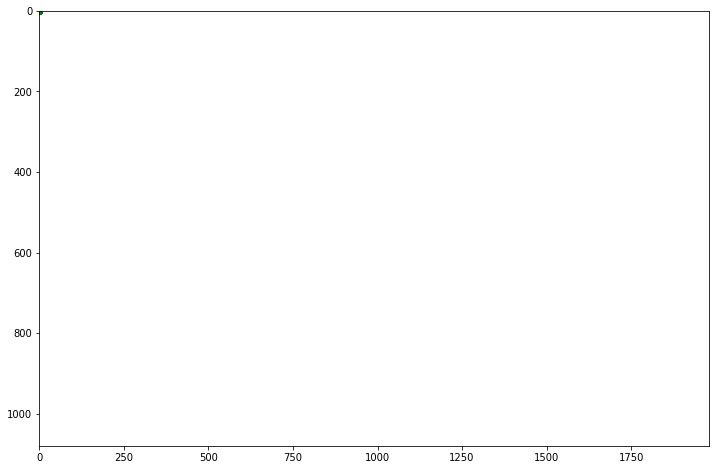

In [84]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(xlim=[0,1980], ylim=[1080,0])
scat = plt.scatter([0] * len(keys), [0] * len(keys), c='g')

In [85]:
def animate(frame, data):
    tmp_offsets = np.empty((len(keys), 2))
    for i, key in enumerate(keys):
        tmp_offsets[i,:] = [data[key][frame][0], data[key][frame][1]]
    scat.set_offsets(tmp_offsets)
    return scat,

In [86]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, fargs=(parsed_data,),
                               frames=300, interval=1000/30)

In [87]:
HTML(anim.to_jshtml())

# WaveGAN (Original)

In [1]:
from wavegan import WaveGANGenerator, WaveGANDiscriminator

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf

In [3]:
_FS = 16000
_WINDOW_LEN = 16384
_D_Z = 100

In [4]:
def train(fps, args):
    with tf.name_scope('loader'):
        x = loader.get_batch(fps, args.train_batch_size, _WINDOW_LEN, args.data_first_window)

    # Make z vector
    z = tf.random_uniform([args.train_batch_size, _D_Z], -1., 1., dtype=tf.float32)

    # Make generator
    with tf.variable_scope('G'):
        G_z = WaveGANGenerator(z, train=True, **args.wavegan_g_kwargs)
        if args.wavegan_genr_pp:
            with tf.variable_scope('pp_filt'):
        G_z = tf.layers.conv1d(G_z, 1, args.wavegan_genr_pp_len, use_bias=False, padding='same')
    G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G')

    # Print G summary
    print('-' * 80)
    print('Generator vars')
    nparams = 0
    for v in G_vars:
        v_shape = v.get_shape().as_list()
        v_n = reduce(lambda x, y: x * y, v_shape)
        nparams += v_n
        print('{} ({}): {}'.format(v.get_shape().as_list(), v_n, v.name))
    print('Total params: {} ({:.2f} MB)'.format(nparams, (float(nparams) * 4) / (1024 * 1024)))

    # Summarize
    tf.summary.audio('x', x, _FS)
    tf.summary.audio('G_z', G_z, _FS)
    G_z_rms = tf.sqrt(tf.reduce_mean(tf.square(G_z[:, :, 0]), axis=1))
    x_rms = tf.sqrt(tf.reduce_mean(tf.square(x[:, :, 0]), axis=1))
    tf.summary.histogram('x_rms_batch', x_rms)
    tf.summary.histogram('G_z_rms_batch', G_z_rms)
    tf.summary.scalar('x_rms', tf.reduce_mean(x_rms))
    tf.summary.scalar('G_z_rms', tf.reduce_mean(G_z_rms))

    # Make real discriminator
    with tf.name_scope('D_x'), tf.variable_scope('D'):
        D_x = WaveGANDiscriminator(x, **args.wavegan_d_kwargs)
    D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D')

    # Print D summary
    print('-' * 80)
    print('Discriminator vars')
    nparams = 0
        for v in D_vars:
        v_shape = v.get_shape().as_list()
        v_n = reduce(lambda x, y: x * y, v_shape)
        nparams += v_n
        print('{} ({}): {}'.format(v.get_shape().as_list(), v_n, v.name))
    print('Total params: {} ({:.2f} MB)'.format(nparams, (float(nparams) * 4) / (1024 * 1024)))
    print('-' * 80)

    # Make fake discriminator
    with tf.name_scope('D_G_z'), tf.variable_scope('D', reuse=True):
        D_G_z = WaveGANDiscriminator(G_z, **args.wavegan_d_kwargs)

    # Create loss
    D_clip_weights = None
    if args.wavegan_loss == 'dcgan':
        fake = tf.zeros([args.train_batch_size], dtype=tf.float32)
        real = tf.ones([args.train_batch_size], dtype=tf.float32)

        G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_G_z,
          labels=real
        ))

        D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_G_z,
          labels=fake
        ))
        D_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=D_x,
          labels=real
        ))

        D_loss /= 2.
    elif args.wavegan_loss == 'lsgan':
        G_loss = tf.reduce_mean((D_G_z - 1.) ** 2)
        D_loss = tf.reduce_mean((D_x - 1.) ** 2)
        D_loss += tf.reduce_mean(D_G_z ** 2)
        D_loss /= 2.
    elif args.wavegan_loss == 'wgan':
        G_loss = -tf.reduce_mean(D_G_z)
        D_loss = tf.reduce_mean(D_G_z) - tf.reduce_mean(D_x)

        with tf.name_scope('D_clip_weights'):
            clip_ops = []
            for var in D_vars:
                clip_bounds = [-.01, .01]
                clip_ops.append(
                  tf.assign(
                    var,
                    tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
                  )
                )
            D_clip_weights = tf.group(*clip_ops)
        elif args.wavegan_loss == 'wgan-gp':
        G_loss = -tf.reduce_mean(D_G_z)
        D_loss = tf.reduce_mean(D_G_z) - tf.reduce_mean(D_x)

        alpha = tf.random_uniform(shape=[args.train_batch_size, 1, 1], minval=0., maxval=1.)
        differences = G_z - x
        interpolates = x + (alpha * differences)
        with tf.name_scope('D_interp'), tf.variable_scope('D', reuse=True):
            D_interp = WaveGANDiscriminator(interpolates, **args.wavegan_d_kwargs)

        LAMBDA = 10
        gradients = tf.gradients(D_interp, [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1, 2]))
        gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2.)
        D_loss += LAMBDA * gradient_penalty
    else:
        raise NotImplementedError()

    tf.summary.scalar('G_loss', G_loss)
    tf.summary.scalar('D_loss', D_loss)

    # Create (recommended) optimizer
    if args.wavegan_loss == 'dcgan':
        G_opt = tf.train.AdamOptimizer(
            learning_rate=2e-4,
            beta1=0.5)
        D_opt = tf.train.AdamOptimizer(
            learning_rate=2e-4,
            beta1=0.5)
    elif args.wavegan_loss == 'lsgan':
        G_opt = tf.train.RMSPropOptimizer(
            learning_rate=1e-4)
        D_opt = tf.train.RMSPropOptimizer(
            learning_rate=1e-4)
    elif args.wavegan_loss == 'wgan':
        G_opt = tf.train.RMSPropOptimizer(
            learning_rate=5e-5)
        D_opt = tf.train.RMSPropOptimizer(
            learning_rate=5e-5)
    elif args.wavegan_loss == 'wgan-gp':
        G_opt = tf.train.AdamOptimizer(
            learning_rate=1e-4,
            beta1=0.5,
            beta2=0.9)
        D_opt = tf.train.AdamOptimizer(
            learning_rate=1e-4,
            beta1=0.5,
            beta2=0.9)
    else:
        raise NotImplementedError()

  # Create training ops
    G_train_op = G_opt.minimize(G_loss, var_list=G_vars,
      global_step=tf.train.get_or_create_global_step())
    D_train_op = D_opt.minimize(D_loss, var_list=D_vars)

    # Run training
    with tf.train.MonitoredTrainingSession(
        checkpoint_dir=args.train_dir,
        save_checkpoint_secs=args.train_save_secs,
        save_summaries_secs=args.train_summary_secs) as sess:
        while True:
            # Train discriminator
            for i in range(args.wavegan_disc_nupdates):
                sess.run(D_train_op)

            # Enforce Lipschitz constraint for WGAN
            if D_clip_weights is not None:
                sess.run(D_clip_weights)

            # Train generator
            sess.run(G_train_op)

In [5]:
def infer(args):
    infer_dir = os.path.join(args.train_dir, 'infer')
    if not os.path.isdir(infer_dir):
        os.makedirs(infer_dir)

    # Subgraph that generates latent vectors
    samp_z_n = tf.placeholder(tf.int32, [], name='samp_z_n')
    samp_z = tf.random_uniform([samp_z_n, _D_Z], -1.0, 1.0, dtype=tf.float32, name='samp_z')

    # Input zo
    z = tf.placeholder(tf.float32, [None, _D_Z], name='z')
    flat_pad = tf.placeholder(tf.int32, [], name='flat_pad')

    # Execute generator
    with tf.variable_scope('G'):
        G_z = WaveGANGenerator(z, train=False, **args.wavegan_g_kwargs)
        if args.wavegan_genr_pp:
            with tf.variable_scope('pp_filt'):
                G_z = tf.layers.conv1d(G_z, 1, args.wavegan_genr_pp_len, use_bias=False, padding='same')
    G_z = tf.identity(G_z, name='G_z')

    # Flatten batch
    nch = int(G_z.get_shape()[-1])
    G_z_padded = tf.pad(G_z, [[0, 0], [0, flat_pad], [0, 0]])
    G_z_flat = tf.reshape(G_z_padded, [-1, nch], name='G_z_flat')

    # Encode to int16
    def float_to_int16(x, name=None):
        x_int16 = x * 32767.
        x_int16 = tf.clip_by_value(x_int16, -32767., 32767.)
        x_int16 = tf.cast(x_int16, tf.int16, name=name)
        return x_int16
    G_z_int16 = float_to_int16(G_z, name='G_z_int16')
    G_z_flat_int16 = float_to_int16(G_z_flat, name='G_z_flat_int16')

    # Create saver
    G_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='G')
    global_step = tf.train.get_or_create_global_step()
    saver = tf.train.Saver(G_vars + [global_step])

    # Export graph
    tf.train.write_graph(tf.get_default_graph(), infer_dir, 'infer.pbtxt')

    # Export MetaGraph
    infer_metagraph_fp = os.path.join(infer_dir, 'infer.meta')
    tf.train.export_meta_graph(
        filename=infer_metagraph_fp,
        clear_devices=True,
        saver_def=saver.as_saver_def())

    # Reset graph (in case training afterwards)
    tf.reset_default_graph()

In [8]:
import argparse
parser = argparse.ArgumentParser([])
parser.set_defaults(
    data_dir=None,
    data_first_window=False,
    wavegan_kernel_len=25,
    wavegan_dim=64,
    wavegan_batchnorm=False,
    wavegan_disc_nupdates=5,
    wavegan_loss='wgan-gp',
    wavegan_genr_upsample='zeros',
    wavegan_genr_pp=False,       # Can change to False or True
    wavegan_genr_pp_len=512,
    wavegan_disc_phaseshuffle=0, # Can change to 0 or 2
    train_batch_size=64,
    train_save_secs=120,
    train_summary_secs=60,
    preview_n=32,)
args = parser.parse_args([])


# Make model kwarg dicts
setattr(args, 'wavegan_g_kwargs', {
  'kernel_len': args.wavegan_kernel_len,
  'dim': args.wavegan_dim,
  'use_batchnorm': args.wavegan_batchnorm,
  'upsample': args.wavegan_genr_upsample
})
setattr(args, 'wavegan_d_kwargs', {
  'kernel_len': args.wavegan_kernel_len,
  'dim': args.wavegan_dim,
  'use_batchnorm': args.wavegan_batchnorm,
  'phaseshuffle_rad': args.wavegan_disc_phaseshuffle
})


In [9]:
setattr(args, 'mode', 'train')
setattr(args, 'train_dir', './train')
setattr(args, 'data_dir', './drums')

In [10]:
import loader
from functools import reduce
import os
import glob

# Assign appropriate split for mode
if args.mode == 'train':
    split = 'train'
else:
    split = None

In [ ]:
fps = glob.glob(os.path.join(args.data_dir, split) + '*.tfrecord')

In [11]:
infer(args)

In [ ]:
train(fps, args)

420

# Generation

In [12]:
import numpy as np
import tensorflow as tf

In [18]:
from IPython.display import display, Audio

# Load the graph
tf.reset_default_graph()
saver = tf.train.import_meta_graph('./train/infer/infer.meta')
graph = tf.get_default_graph()
sess = tf.InteractiveSession()
saver.restore(sess, './train/model.ckpt-3506')

INFO:tensorflow:Restoring parameters from ./train/model.ckpt-3506


In [73]:
# Create 50 random latent vectors z
_z = (np.random.rand(50, 100) * 2.) - 1

# Synthesize G(z)
z = graph.get_tensor_by_name('z:0')
G_z = graph.get_tensor_by_name('G_z:0')
_G_z = sess.run(G_z, {z: _z})

# Play audio in notebook
Audio(_G_z[0].reshape(-1,), rate=16000)

In [70]:
output = np.array(_G_z[0])

In [48]:
output.shape

(16384, 1)

In [51]:
output = np.concatenate((output,_G_z[0]))

In [52]:
output.shape

(49152, 1)

In [55]:
Audio(output.reshape(-1,), rate=24000)

In [ ]:
# Convert 